# Convolution Neural Networks (CNN) - ResNet50 (Fine tuned)

###  Deep learning on images

Classify images into two categories(AG vs PR) using fine tuned ResNet50 model and Keras library.

#### ResNet50

Unlike traditional sequential network architectures such as AlexNet, OverFeat, and VGG, ResNet is instead a form of “exotic architecture” that relies on micro-architecture modules (also called “network-in-network architectures”).

The term micro-architecture refers to the set of “building blocks” used to construct the network. A collection of micro-architecture building blocks (along with your standard CONV, POOL, etc. layers) leads to the macro-architecture (i.e,. the end network itself)

First introduced by He et al. in their 2015 paper, Deep Residual Learning for Image Recognition - https://arxiv.org/abs/1512.03385. Further accuracy can be obtained by updating the residual module to use identity mappings, as demonstrated in their 2016 followup publication, Identity Mappings in Deep Residual Networks - https://arxiv.org/abs/1603.05027


For example:
 - **include_top** (True): Whether or not to include the output layers for the model. You don’t need these if you are fitting the model on your own problem.
 - **weights** (‘imagenet‘): What weights to load. You can specify None to not load pre-trained weights if you are interested in training the model yourself from scratch.
 - **input_tensor** (None): A new input layer if you intend to fit the model on new data of a different size.
 - **input_shape** (None): The size of images that the model is expected to take if you change the input layer.
 - **pooling** (None): The type of pooling to use when you are training a new set of output layers.
 - **classes** (2): The number of classes (e.g. size of output vector) for the model.
 
Note: we'll be using the loaded ResNet model to classify ad hoc photographs.

#### Reference:
https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

### Importing libraries and splitting the dataset

In [18]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Activation, Flatten, Dropout
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras import optimizers
from keras import backend as k 
from keras.utils.vis_utils import plot_model
from keras import regularizers
import matplotlib.pyplot as plt
import tensorflow as tf
import os.path
from os import path

In [2]:
# relative path to the train, test and validation data
train_path = 'data/train'
valid_path = 'data/valid'
test_path  = 'data/test'

In [3]:
# rescale: rescaling factor. Defaults to None. If None or 0, no rescaling is applied, otherwise we multiply the data by the value provided (after applying all other transformations).
# rotation_range is a value in degrees (0–180), a range within which to ran- domly rotate pictures.
# zoom_range is for randomly zooming inside pictures.
# shear_range is for randomly applying shearing transformations.
# horizontal_flip is for randomly flipping half the images horizontally—rele-vant when there are no 
# assumptions of horizontal asymmetry (for example, real-world pictures).
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    fill_mode='nearest')

# validation data should not be augmented
valid_datagen = ImageDataGenerator(rescale=1./255)

# validation and test datagen should be same
test_datagen = ImageDataGenerator(rescale=1./255)

In [40]:
# The input training images can be of any size and target_size parameter will resize the input images to 224x224
train_batch_size = 32
valid_batch_size =32
test_batch_size = 132

train_batches = train_datagen.flow_from_directory(train_path, target_size=(224,224), classes=['Ankur', 'Priyanka'], batch_size=train_batch_size)
valid_batches = valid_datagen.flow_from_directory(valid_path, target_size=(224,224), classes=['Ankur', 'Priyanka'], batch_size=valid_batch_size)
test_batches  = test_datagen.flow_from_directory(test_path, target_size=(224,224), classes=['Ankur', 'Priyanka'], batch_size=test_batch_size)

Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 132 images belonging to 2 classes.


### Visualizing Training images

{'Ankur': 0, 'Priyanka': 1}


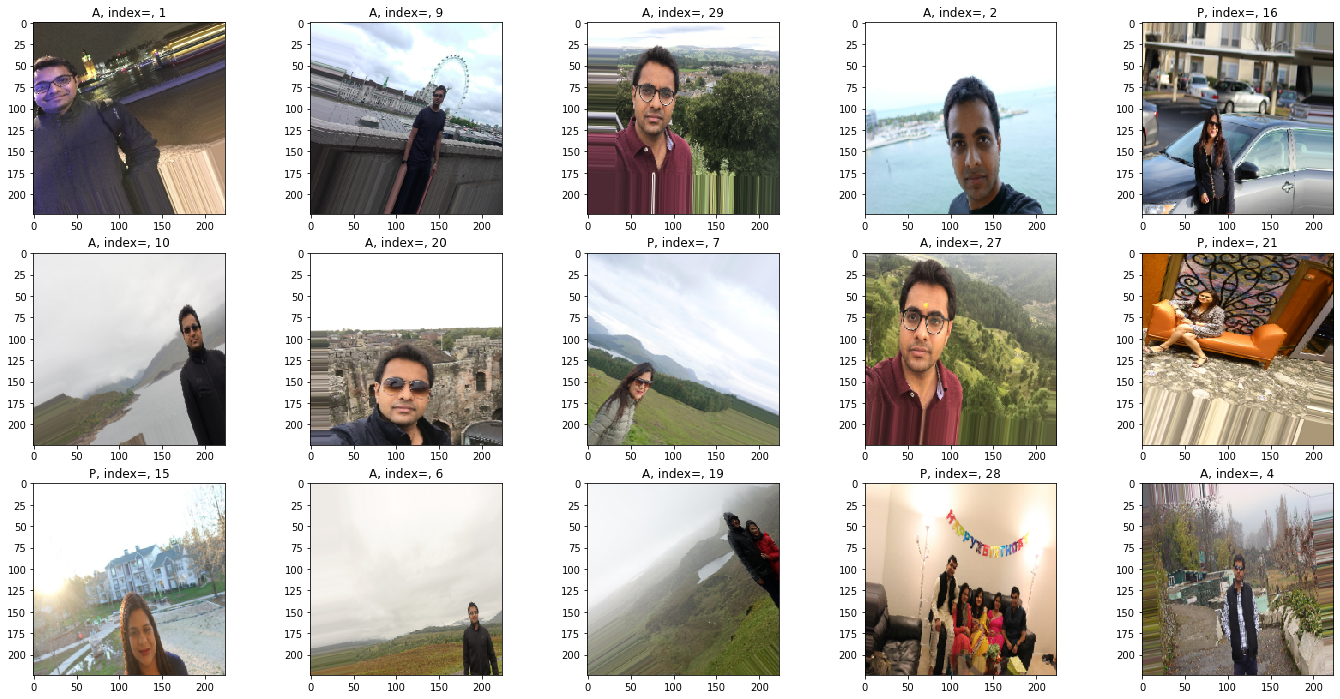

In [7]:
columns = 5
train_images, train_labels = next(train_batches)
print(train_batches.class_indices)
index = []

for i in range(25):
    r = np.random.randint(1, train_batch_size-1)
    if r not in index: index.append(r)

plt.figure(figsize=(24,12))
for i in range(1, 16):
    plt.subplot(3, columns, i)
    plt.imshow(train_images[index[i]])
    if (np.argmax(train_labels[index[i]], axis = 0) == 0):
         plt.title('{0}, {1}, {2}'.format('A', 'index=', index[i]))
    elif (np.argmax(train_labels[index[i]], axis = 0) == 1):
         plt.title('{0}, {1}, {2}'.format('P', 'index=', index[i]))
plt.show()

### Build Model

In [26]:
# Keras will download the ResNet50 model to your system
resNet50_model = keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# ResNet50 is not of type Sequential.
print("Type of model: %s" % type(resNet50_model))

# print the number of layers in the model
print("Number of layers: %d" % (len(resNet50_model.layers)))

# create a plot of the layers in the ResNet50 model, as follows:
if (not path.isfile('ResNet50_without_top_layer.png')):
    plot_model(resNet50_model, to_file='ResNet50_without_top_layer.png')

# Freeze the layers except the last 4 layers
for layer in resNet50_model.layers[:-4]:
    layer.trainable = False

/home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Type of model: <class 'keras.engine.training.Model'>
Number of layers: 175


In [19]:
# Create a new model
model_cnn = Sequential()

# Add the ResNet50 convolution base model
model_cnn.add(resNet50_model)

# Flatten layer
model_cnn.add(Flatten())

# Dropout layer
model_cnn.add(Dropout(0.5))

# output layer
model_cnn.add(Dense(2, activation='softmax'))

# type of model
print(type(model_cnn))

# print the number of layers in the model
print(len(model_cnn.layers))

W0813 19:45:44.254822 140709006525824 deprecation.py:506] From /home/agoel/anaconda3/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


<class 'keras.engine.sequential.Sequential'>
4


In [20]:
# Model summary
model_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 200706    
Total params: 23,788,418
Trainable params: 23,735,298
Non-trainable params: 53,120
_________________________________________________________________


In [21]:
# compile model summary
model_cnn.compile(loss='binary_crossentropy', 
                  #optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), 
                  optimizer=optimizers.Adam(lr=1e-4), 
                  metrics = ['accuracy'])

### Training the Fine tuned ResNet50 model

In [22]:
print ('steps_per_epoch: %d' % (train_batches.samples/train_batches.batch_size))
print ('validation_steps:%d' % (valid_batches.samples/valid_batches.batch_size))

import gc
print(gc.collect())

# By default, shuffle is True and it tells that the order of data your model is 
# iterating with each run/epoch will be different.
history = model_cnn.fit_generator(train_batches, 
                    steps_per_epoch=train_batches.samples/train_batches.batch_size,
                    validation_data=valid_batches, 
                    validation_steps=valid_batches.samples/valid_batches.batch_size, 
                    epochs=10, 
                    verbose=1)

steps_per_epoch: 15
validation_steps:3
66
Epoch 1/10
15/15 [==============================] - 40s 3s/step - loss: 0.4138 - acc: 0.8938 - val_loss: 0.1802 - val_acc: 0.9583
Epoch 2/10
15/15 [==============================] - 15s 977ms/step - loss: 0.1167 - acc: 0.9708 - val_loss: 0.2533 - val_acc: 0.9583
Epoch 3/10
15/15 [==============================] - 15s 980ms/step - loss: 0.1151 - acc: 0.9646 - val_loss: 0.1731 - val_acc: 0.9667
Epoch 4/10
15/15 [==============================] - 15s 978ms/step - loss: 0.1886 - acc: 0.9667 - val_loss: 0.4387 - val_acc: 0.9250
Epoch 5/10
15/15 [==============================] - 15s 978ms/step - loss: 0.0565 - acc: 0.9875 - val_loss: 0.2313 - val_acc: 0.9667
Epoch 6/10
15/15 [==============================] - 15s 978ms/step - loss: 0.0339 - acc: 0.9917 - val_loss: 0.5072 - val_acc: 0.9333
Epoch 7/10
15/15 [==============================] - 16s 1s/step - loss: 0.0711 - acc: 0.9812 - val_loss: 0.8479 - val_acc: 0.9000
Epoch 8/10
15/15 [===============

### Save Model

In [15]:
# Save the file only if it's not already present.
print (not path.isfile('ResNet50_AP.h5'))

if (not path.isfile('ResNet50_AP.h5')):
    model_cnn.save('ResNet50_AP.h5')

True


### Displaying curves of loss and accuracy during training

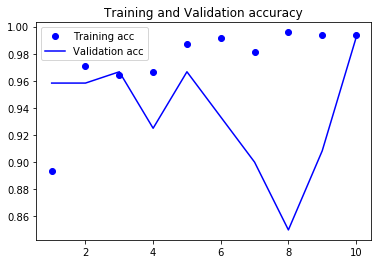

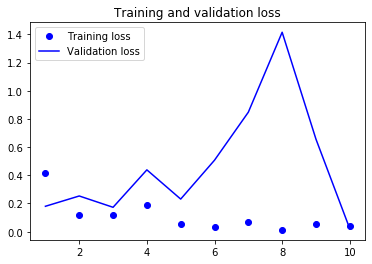

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# get the number of epochs
epochs = range(1, len(acc) + 1)

# Plot accuracy of Training and Validation set
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Predict using fine tuned ResNet50 model

In [24]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

{'Ankur': 0, 'Priyanka': 1}


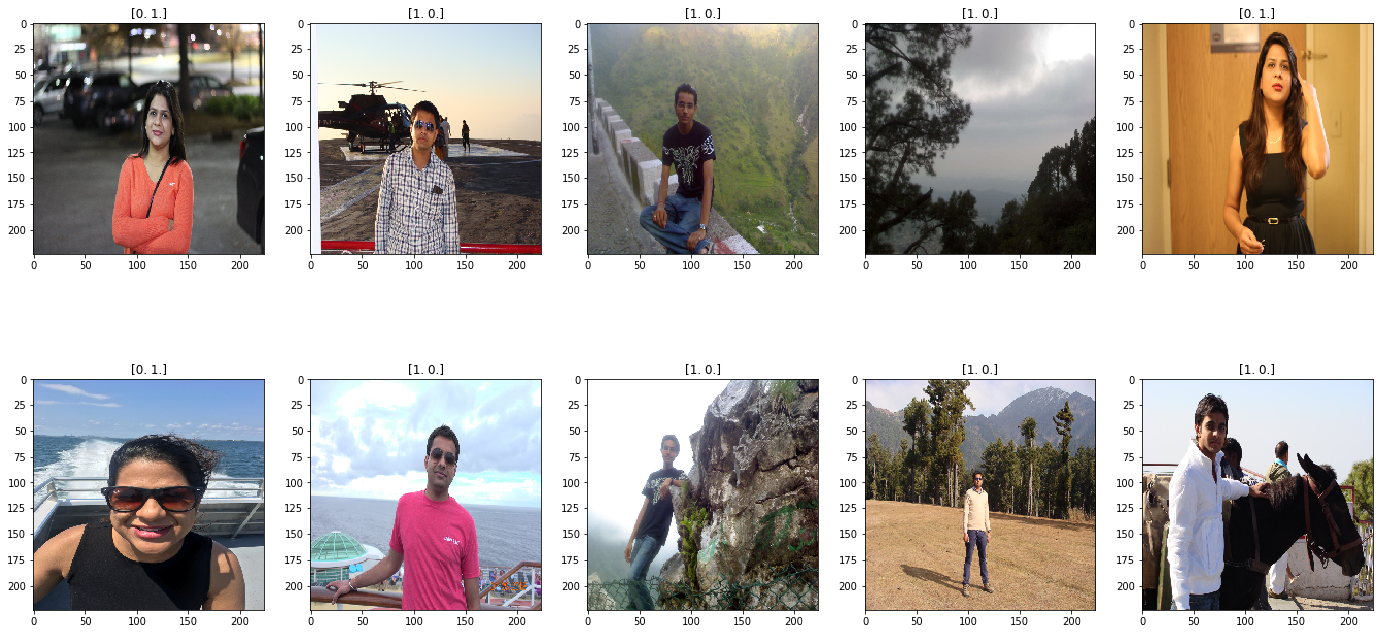

In [42]:
# Ankur's images are labeled as (1,0) and Priyanka's images are labeled as (0,1)
test_imgs, test_labels = next(test_batches)

# Grab the batch of next test images.
test_imgs = test_imgs[0:15, :]
test_labels = test_labels[0:15, :]
columns = 5

# Displays the indiices of the labels
print(test_batches.class_indices)

plt.figure(figsize=(24,12))
for i in range(10):
    plt.subplot(5/columns+1, columns, i+1)
    plt.imshow(test_imgs[i])
    plt.title(test_labels[i])

In [43]:
# Ankur's images will be labeled as 1 instead of (1,0) 
# and Priyanka's imges will be labeled as 0 instead of (0,1)
test_labels = test_labels[:,0]
print(test_labels)

[0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1.]
